In [189]:
# Import libraries to be used.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

In [190]:
# Define a random state value
RANDOM_STATE = 3030

In [191]:
# Define column names which will be used instead of the ones in the datasets.
column_names = [
    "age", "sex", "chest_pain_type", "rest_bp", "cholesterol",
    "fasting_bs", "resting_ecg", "max_hr", "exercise_angina", "st_exercise_depression",
    "st_exercise_slope", "major_vessels_fluorospy", "thal", "angiographic_disease"
]
na_values = ["?"] # Define what values will be interpreted as missing values, in this dataset the "?" character is used for this.

# Load all datasets using relative paths and combine into one dataframe.
df = pd.concat([
    pd.read_csv("../data/processed.cleveland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.hungarian.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.switzerland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.va.data", names=column_names, na_values=na_values)
]).drop(['st_exercise_slope', 'major_vessels_fluorospy', 'thal'], axis=1)

In [192]:
df[df["angiographic_disease"] > 1] = 1

In [193]:
df['age'].fillna((df['age'].mean()), inplace=True)
df['rest_bp'].fillna((df['rest_bp'].mean()), inplace=True)
df['cholesterol'].fillna((df['cholesterol'].mean()), inplace=True)
df['max_hr'].fillna((df['max_hr'].mean()), inplace=True)
df['st_exercise_depression'].fillna((df['st_exercise_depression'].mean()), inplace=True)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [194]:
# Set category attributes
df["sex"] = df["sex"].astype("category")
df["chest_pain_type"] = df["chest_pain_type"].astype("category")
df["fasting_bs"] = df["fasting_bs"].astype("category")
df["resting_ecg"] = df["resting_ecg"].astype("category")
df["exercise_angina"] = df["exercise_angina"].astype("category")
df["angiographic_disease"] = df["angiographic_disease"].astype("category")

In [195]:
df_X = df.drop(["angiographic_disease"], axis=1)

In [196]:
X = MinMaxScaler().fit_transform(df_X.to_numpy())
Y = df["angiographic_disease"].to_numpy()

In [197]:
def evaluate_model(estimator, params, estimator_name):
    print("******** STARTING TRAINING AND EVALUATION OF {} ********".format(estimator_name))
    evaluation_results = {}
    calculated_scores = []
    SCORERS = ["roc_auc", "f1_macro", "accuracy", 'recall', 'precision', 'jaccard']
    # GS_PARAMETERS = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1, 5, 10]}
    CV_K = 10

    for i in range(0, 5):
        n_features = 2*(i+1)
        # Find the best k features
        select_k_best = SelectKBest(chi2, k=n_features).fit(X, Y)
        X_new = select_k_best.transform(X)

        # Perform grid search to find the best estimator for this feature set
        clf = GridSearchCV(estimator=estimator, param_grid=params, refit=False)
        clf.fit(X_new, Y)
        best_estimator = clone(estimator).set_params(**clf.best_params_)

        index_name = "{}_features".format(n_features)
        selected_features = select_k_best.get_feature_names_out(input_features=df_X.columns)
        evaluation_results[index_name] = {"scores": {}, "features": selected_features, "best_estimator": best_estimator}

        print("Running {}-CV with features={}, estimator={}".format(CV_K, selected_features, best_estimator))

        # Perform cross-validation in order to evaluate the best parameter found by grid-search on the feature set.
        scores = cross_validate(estimator=best_estimator, X=X_new, y=Y, cv=CV_K, scoring=SCORERS)
        # Retrieve names of scores for visualization purposes.
        for key in scores.keys():
            if ("test_" in key):
                score_name = key.split("test_")[1]
                if (score_name not in calculated_scores):
                    calculated_scores.append(score_name)
                evaluation_results[index_name]["scores"][score_name] = scores[key]
    
    scores_to_plot = {}
    # Plot settings.
    plt.rcParams.update({'font.size': 13})
    plt.figure(figsize=(30,15))

    for i, score_name in enumerate(calculated_scores):
        scores_to_plot[score_name] = {}
        for feat_set in evaluation_results.keys():
            scores_to_plot[score_name][feat_set] = np.mean(evaluation_results[feat_set]["scores"][score_name])
        # Plot data.
        plt.subplot(2, 3, i+1)
        plt.bar(scores_to_plot[score_name].keys(), scores_to_plot[score_name].values())
        plt.title("{} over feature sets, {}".format(score_name, estimator_name))
        plt.grid()

    feature_set_keys = scores_to_plot[list(scores_to_plot.keys())[0]].keys()
    rows = []
    index_names = list(scores_to_plot.keys())
    index_names.append("best_estimator")

    # Gather scores by metric.
    for score in scores_to_plot.keys():
        score_averages = []
        for feat_set in scores_to_plot[score].keys():
            score_averages.append(scores_to_plot[score][feat_set])
        rows.append(score_averages)

    # Supplement rows with the best estimator by feature set.
    best_estimators = []
    for feat_set in evaluation_results.keys():
        best_estimators.append(evaluation_results[feat_set]["best_estimator"])
    rows.append(best_estimators)

    return pd.DataFrame(data=rows, columns=evaluation_results.keys(), index=index_names)

******** STARTING TRAINING AND EVALUATION OF SVM ********
Running 10-CV with features=['fasting_bs' 'exercise_angina'], estimator=SVC(C=1, kernel='linear', random_state=3030)
Running 10-CV with features=['rest_bp' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=SVC(C=1, kernel='linear', random_state=3030)
Running 10-CV with features=['age' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=SVC(C=1, kernel='linear', random_state=3030)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'max_hr' 'exercise_angina'], estimator=SVC(C=1, kernel='poly', random_state=3030)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'resting_ecg' 'max_hr' 'exercise_angina' 'st_exercise_depression'], estimator=SVC(C=10, kernel='linear', random_state=3030)


,2_features,4_features,6_features,8_features,10_features
roc_auc,0.803622,0.830953,0.811452,0.866617,0.87838
f1_macro,0.79695,0.79695,0.79695,0.817237,0.803475
accuracy,0.802174,0.802174,0.802174,0.821739,0.811957
recall,0.789765,0.789765,0.789765,0.789765,0.795647
precision,0.858756,0.858756,0.858756,0.894772,0.883573
jaccard,0.692409,0.692409,0.692409,0.716667,0.708885
best_estimator,"SVC(C=1, kernel='linear', random_state=3030)","SVC(C=1, kernel='linear', random_state=3030)","SVC(C=1, kernel='linear', random_state=3030)","SVC(C=1, kernel='poly', random_state=3030)","SVC(C=10, kernel='linear', random_state=3030)"


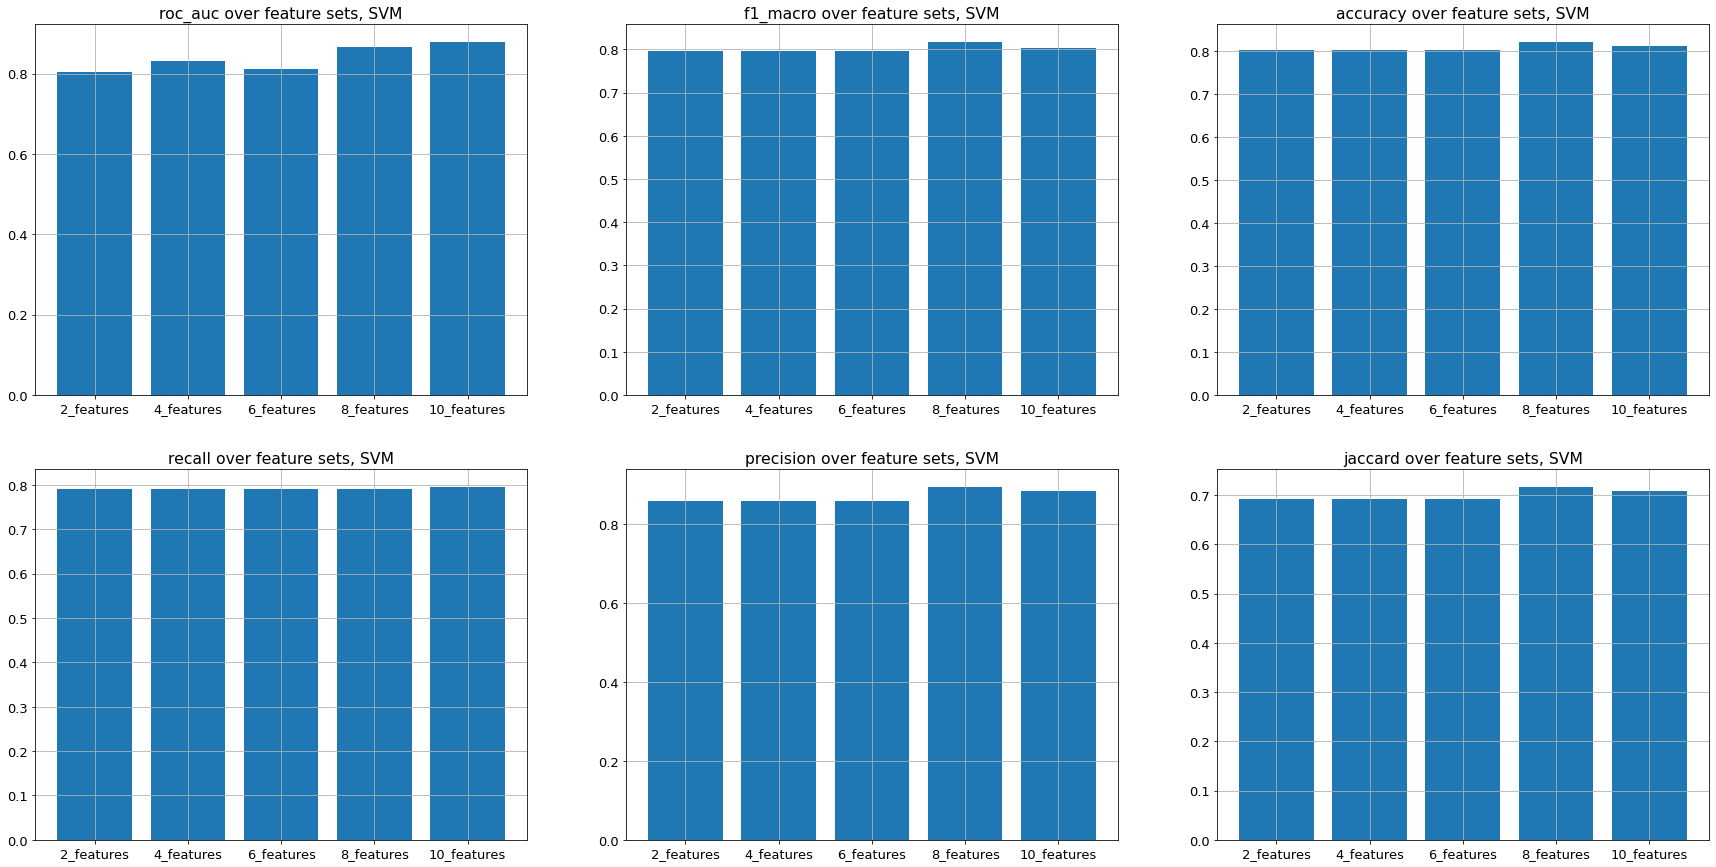

In [198]:
evaluate_model(estimator=SVC(random_state=RANDOM_STATE), params={'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1, 5, 10]}, estimator_name="SVM")

******** STARTING TRAINING AND EVALUATION OF KNN ********
Running 10-CV with features=['fasting_bs' 'exercise_angina'], estimator=KNeighborsClassifier(n_neighbors=13, p=1)
Running 10-CV with features=['rest_bp' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=KNeighborsClassifier(n_neighbors=11)
Running 10-CV with features=['age' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=KNeighborsClassifier(n_neighbors=13)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'max_hr' 'exercise_angina'], estimator=KNeighborsClassifier(n_neighbors=9, p=1)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'resting_ecg' 'max_hr' 'exercise_angina' 'st_exercise_depression'], estimator=KNeighborsClassifier(n_neighbors=11)


,2_features,4_features,6_features,8_features,10_features
roc_auc,0.843928,0.85043,0.852125,0.89883,0.895462
f1_macro,0.764331,0.792526,0.799267,0.805025,0.804178
accuracy,0.772826,0.797826,0.807609,0.811957,0.809783
recall,0.658039,0.772078,0.805373,0.815294,0.801529
precision,0.918791,0.86605,0.864485,0.860146,0.86368
jaccard,0.611831,0.684507,0.707915,0.714124,0.703461
best_estimator,"KNeighborsClassifier(n_neighbors=13, p=1)",KNeighborsClassifier(n_neighbors=11),KNeighborsClassifier(n_neighbors=13),"KNeighborsClassifier(n_neighbors=9, p=1)",KNeighborsClassifier(n_neighbors=11)


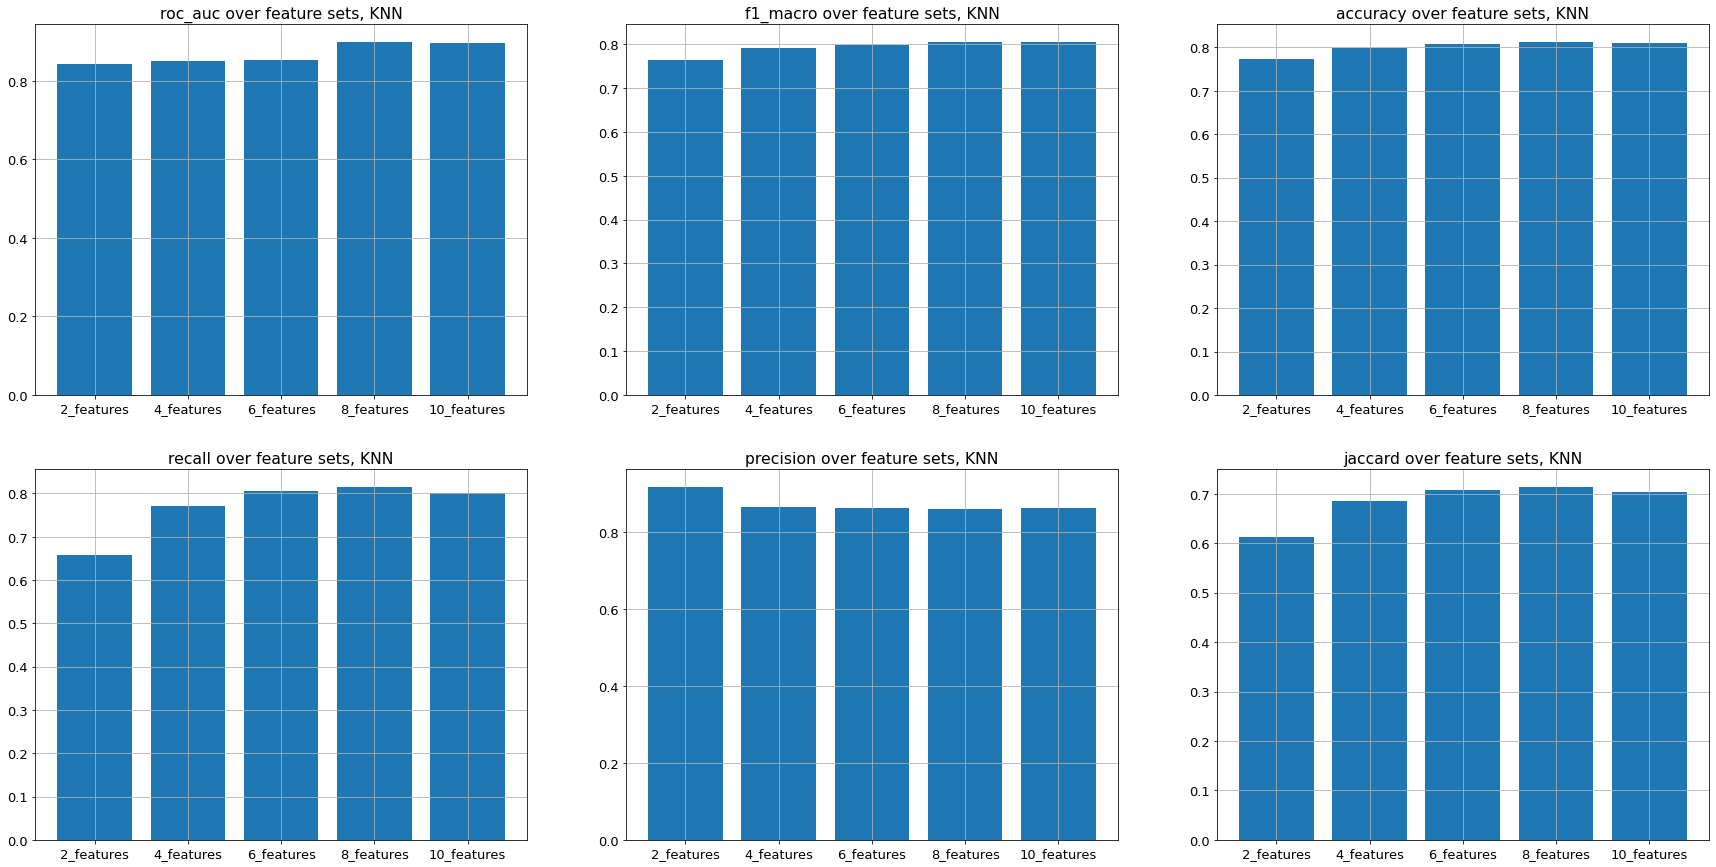

In [199]:
evaluate_model(estimator=KNeighborsClassifier(), params={'n_neighbors': [1, 3, 5, 7, 9, 11, 13], 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'), 'p': [1, 2]}, estimator_name="KNN")

******** STARTING TRAINING AND EVALUATION OF RF ********
Running 10-CV with features=['fasting_bs' 'exercise_angina'], estimator=RandomForestClassifier(n_estimators=1, random_state=3030)
Running 10-CV with features=['rest_bp' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=RandomForestClassifier(criterion='entropy', n_estimators=47, random_state=3030)
Running 10-CV with features=['age' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr' 'exercise_angina'], estimator=RandomForestClassifier(n_estimators=47, random_state=3030)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'max_hr' 'exercise_angina'], estimator=RandomForestClassifier(criterion='entropy', n_estimators=23, random_state=3030)
Running 10-CV with features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'resting_ecg' 'max_hr' 'exercise_angina' 'st_exercise_depression'], estimator=RandomForestClassifier(criterion='entropy', n_estimators=23, random_state=3030)


,2_features,4_features,6_features,8_features,10_features
roc_auc,0.840963,0.826457,0.816359,0.878231,0.875913
f1_macro,0.79695,0.729424,0.738955,0.767409,0.775444
accuracy,0.802174,0.73913,0.75,0.778261,0.78587
recall,0.789765,0.754353,0.758314,0.781922,0.789725
precision,0.858756,0.781719,0.807013,0.838605,0.842904
jaccard,0.692409,0.619055,0.632159,0.669733,0.681734
best_estimator,"RandomForestClassifier(n_estimators=1, random_...","RandomForestClassifier(criterion='entropy', n_...","RandomForestClassifier(n_estimators=47, random...","RandomForestClassifier(criterion='entropy', n_...","RandomForestClassifier(criterion='entropy', n_..."


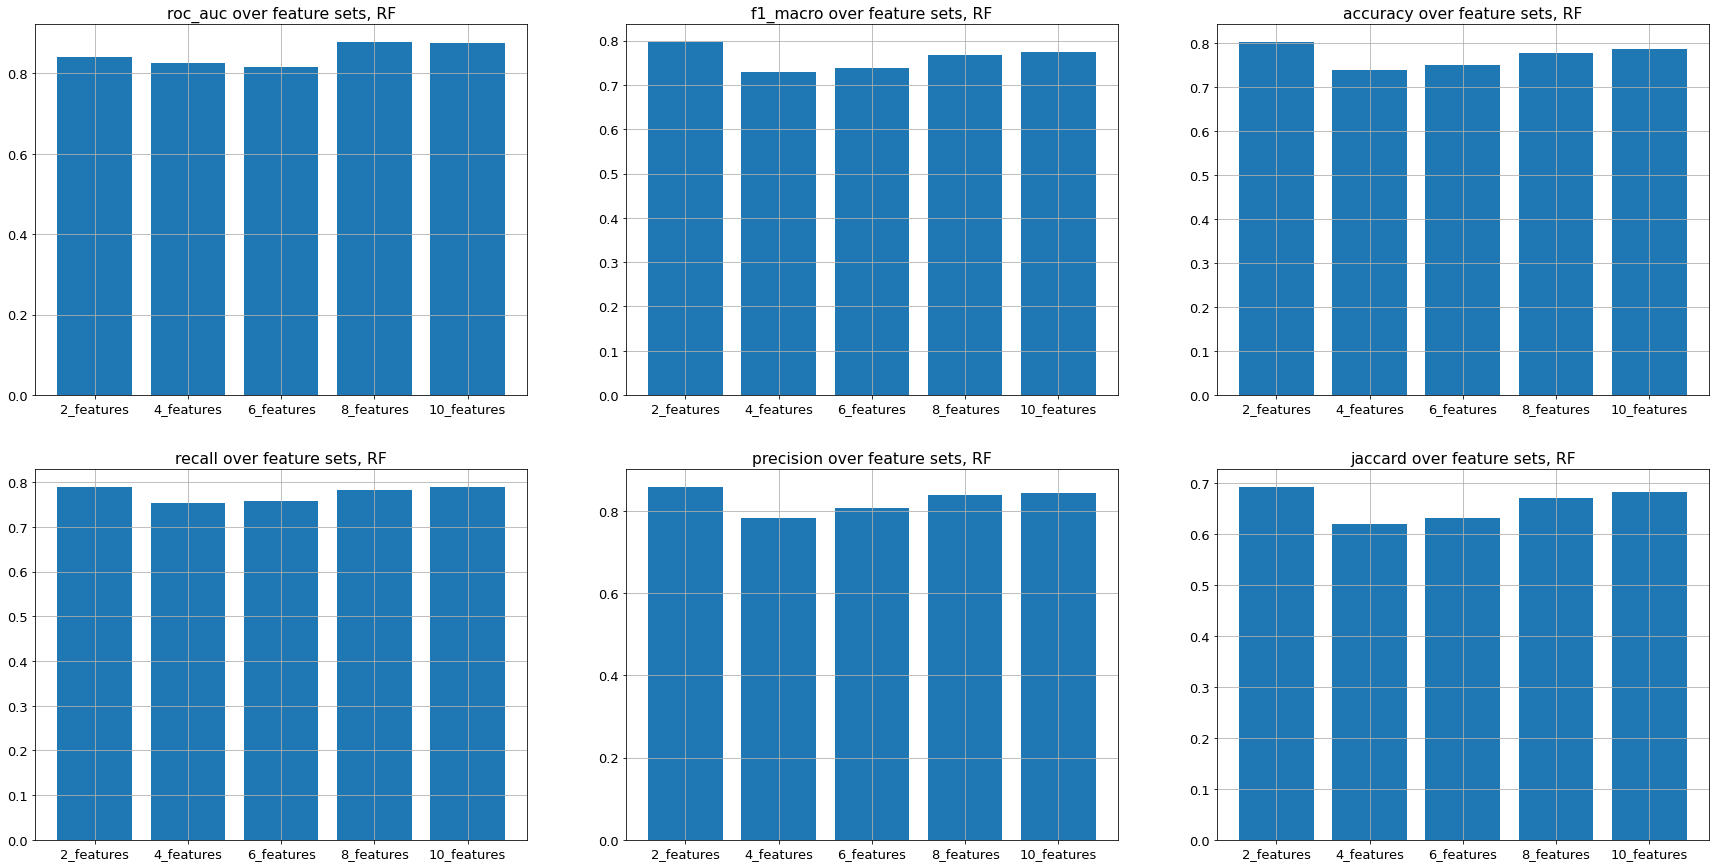

In [200]:
evaluate_model(estimator=RandomForestClassifier(random_state=RANDOM_STATE), params={'n_estimators': [1, 5, 11, 23, 47, 99], 'criterion': ('gini', 'entropy')}, estimator_name="RF")

## Conclusion

### Best feature set and estimator
All feature set/estimator combinations seem to produce very similar metrics, with the exception of the 8-, and 10-feature sets. In these two sets, the 8-feature set slightly outperforms the 10-feature set in all metrics except for in the `ROC_AUC` and `recall` metric, where the differences are also very small. Therefore, the 8-feature set with `C=1` and `kernel='poly'` can be considered to be the most suitable combination of feature set and estimator.